构建仿真环境

In [1]:
from envs.rtb import PandaThreeCylinderEnv,PandaSingleCylinderEnv,PandaCuboidEnv,PandamultiCuboidEnv
cenv = PandaCuboidEnv(launch_args={'realtime': True, 'browser': 'notebook'})
# cenv =PandamultiCuboidEnv(launch_args={'realtime': True, 'browser': 'notebook'})

/home/lichalab/anaconda3/envs/omplall/lib/python3.8/site-packages/spatialgeometry/geom/Shape.py:81: FutureWarning: base kwarg is deprecated, use pose instead
  warn("base kwarg is deprecated, use pose instead", FutureWarning)


定义优化问题

In [2]:
import torch
import numpy as np
from spatialmath import SE3
Tr = cenv.robot.fkine(cenv.robot.qr)
start_point = np.array([0.5, -0.3, 0.3])
target_point = np.array([0.5 ,0.3, 0.5])
Tstart = SE3.Rt(R=Tr.R, t=start_point)
Ttarget = SE3.Rt(R=Tr.R, t=target_point)
print("Tstart=",Tstart)
print("Ttarget=",Ttarget)
print("cenv.robot.qr",cenv.robot.qr)
while True:
    start_cfg = cenv.robot.ikine_LM(Tstart, mask=np.array([1., 1., 1., 1, 1, 1]), q0=cenv.robot.qr).q
    start_cfg = torch.tensor(start_cfg, dtype=torch.float32)
    target_cfg = cenv.robot.ikine_LM(Ttarget, mask=np.array([1., 1., 1., 1, 1, 1]), q0=cenv.robot.qr).q
    target_cfg = torch.tensor(target_cfg, dtype=torch.float32)
    if not any(cenv.is_collision([start_cfg, target_cfg])):
        break

print(f'start_cfg = {start_cfg}, fk_t = {cenv.robot.fkine(start_cfg).t}')
print(f'target_cfg = {target_cfg}, fk_t = {cenv.robot.fkine(target_cfg).t}')
print(f'collision = {cenv.is_collision([start_cfg, target_cfg])}')

Tstart=    0.995     0         0.09983   0.5       
   0        -1         0        -0.3       
   0.09983   0        -0.995     0.3       
   0         0         0         1         

Ttarget=    0.995     0         0.09983   0.5       
   0        -1         0         0.3       
   0.09983   0        -0.995     0.5       
   0         0         0         1         

cenv.robot.qr [ 0.         -0.3         0.         -2.2         0.          2.
  0.78539816]


pybullet build time: Nov 28 2023 23:51:11


start_cfg = tensor([-0.1864,  0.0947, -0.3750, -2.0538,  0.1104,  2.2240,  0.1634]), fk_t = [ 0.49999999 -0.3         0.29999999]
target_cfg = tensor([ 0.1778,  0.0207,  0.3855, -1.6237, -0.0618,  1.7273,  1.3554]), fk_t = [0.5        0.29999999 0.5       ]
collision = [False, False]


场景初始化

In [3]:
tmp_cenv = PandaCuboidEnv(launch_args={'realtime': False, 'browser': 'firefox'})
# tmp_cenv =PandamultiCuboidEnv(launch_args={'realtime': False, 'browser': 'firefox'})
tmp_cenv.robot.q = start_cfg.numpy()
tmp_cenv.env.step(0.01)

/home/lichalab/anaconda3/envs/omplall/lib/python3.8/site-packages/spatialgeometry/geom/Shape.py:81: FutureWarning: base kwarg is deprecated, use pose instead
  warn("base kwarg is deprecated, use pose instead", FutureWarning)


In [4]:
from scripts.motion_planner import MotionPlanner
from sdfsc import model
drobot = model.PandaFK()
def my_motion_cost(s1, s2):
    # print(f'motion cost: {s1}, {s2}')
    p_tensor = torch.stack([s1, s2])
    control_points = drobot.fkine(p_tensor)
    diff = (control_points[1:]-control_points[:-1]).pow(2).sum()
    return diff.item()
def valid_check_func(x):
    # print(f'valid check: {x}')
    if not isinstance(x, np.ndarray):
        x = np.array(x)
    return not cenv._single_collision(x)
# valid_check_func = lambda x: not cenv.is_collision(x)
mp = MotionPlanner(drobot, valid_check_func, my_motion_cost)
ompl_rec = mp.plan(start_cfg, target_cfg, {'maxtime': 50.0})
print(f'OMPL success?: {ompl_rec["success"]}')
ompl_path = torch.tensor(ompl_rec['solution'], dtype=torch.double)
print(ompl_path.shape)

planner: RRTConnect
longest_valid_segment_length=0.13037036341314034
Info:    RRTConnect: Space information setup was not yet called. Calling now.
Debug:   RRTConnect: Planner range detected to be 2.607407
Info:    RRTConnect: Starting planning with 1 states already in datastructure
plan_time= 0.06465268135070801
Info:    RRTConnect: Created 6 states (3 start + 3 goal)
OMPL success?: True
torch.Size([43, 7])


         at line 101 in /home/lichalab/omplapp-all/omplapp-main/ompl/src/ompl/base/src/Planner.cpp


Simple scenario

{'top': tensor(0.1000), 'bottom': tensor(0.1000), 'front': tensor(0.2000), 'back': tensor(0.2000), 'left': tensor(0.2000), 'right': tensor(0.2000)}
{'top': tensor(0.1000), 'bottom': tensor(0.1000), 'front': tensor(0.2000), 'back': tensor(0.2000), 'left': tensor(0.2000), 'right': tensor(0.2000)}
{'top': tensor(0.1000), 'bottom': tensor(0.1000), 'front': tensor(0.2000), 'back': tensor(0.2000), 'left': tensor(0.2000), 'right': tensor(0.2000)}
torch.Size([300, 3])


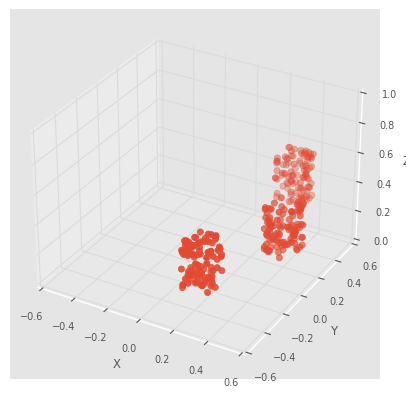

In [6]:
from sdfsc.Obstacles import Obstacle
import matplotlib.pyplot as plt
import torch
obstacles = [
    ('cuboid', [0.3, -0.5, 0.4], [0.15, 0.15, 0.3]),
    ('cuboid', [0.5, 0, 0.4], [0.15, 0.15, 0.3]),
    ('cuboid', [0.3, 0.5, 0.4], [0.15, 0.15, 0.3])
]
obstacles = [Obstacle(*obstacle) for obstacle in obstacles]
points_list = []

for i in range(len(obstacles)):
    points = obstacles[i].points
    points_list.append(points)
all_points = torch.cat(points_list, dim=0)

print(all_points.shape)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim(-0.6, 0.6)  
ax.set_ylim(-0.6, 0.6)  
ax.set_zlim(0, 1) 

ax.scatter(all_points[:, 0], all_points[:, 1], all_points[:, 2])

ax.set_xlabel('X ')
ax.set_ylabel('Y ')
ax.set_zlabel('Z ')

plt.show()

Complex obstacles

{'top': tensor(0.166667), 'bottom': tensor(0.166667), 'front': tensor(0.166667), 'back': tensor(0.166667), 'left': tensor(0.166667), 'right': tensor(0.166667)}
{'top': tensor(0.051020), 'bottom': tensor(0.051020), 'front': tensor(0.408163), 'back': tensor(0.408163), 'left': tensor(0.040816), 'right': tensor(0.040816)}
{'top': tensor(0.166667), 'bottom': tensor(0.166667), 'front': tensor(0.166667), 'back': tensor(0.166667), 'left': tensor(0.166667), 'right': tensor(0.166667)}
{'top': tensor(0.166667), 'bottom': tensor(0.166667), 'front': tensor(0.166667), 'back': tensor(0.166667), 'left': tensor(0.166667), 'right': tensor(0.166667)}
{'top': tensor(0.166667), 'bottom': tensor(0.166667), 'front': tensor(0.166667), 'back': tensor(0.166667), 'left': tensor(0.166667), 'right': tensor(0.166667)}
{'top': tensor(0.166667), 'bottom': tensor(0.166667), 'front': tensor(0.166667), 'back': tensor(0.166667), 'left': tensor(0.166667), 'right': tensor(0.166667)}
{'top': tensor(0.166667), 'bottom': tens

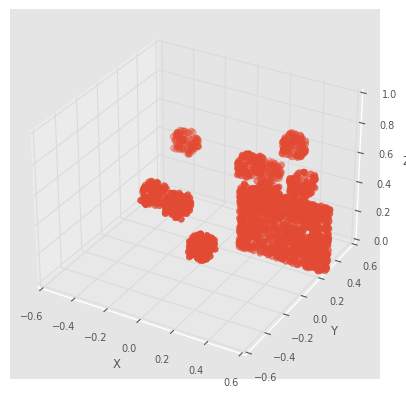

In [17]:
# from sdfsc.Obstacles import Obstacle
# import matplotlib.pyplot as plt
# import torch
# obstacles = [
#     ('cuboid', [0.3, -0.5, 0.5], [0.1, 0.1, 0.1]),
#     ('cuboid', [0.5, 0, 0.4], [0.5, 0.05, 0.4],1000),
#     ('cuboid', [0.2, 0.4, 0.45], [0.1, 0.1, 0.1]),
#     ('cuboid', [0.55, 0.1, 0.65], [0.1, 0.1, 0.1]),
#     ('cuboid', [0.3, -0., 0.75], [0.1, 0.1, 0.1]),
#     ('cuboid', [0.45, -0.1, 0.65], [0.1, 0.1, 0.1]),
#     ('cuboid', [-0.2, 0.2, 0.65], [0.1, 0.1, 0.1]),
#     ('cuboid', [0.4, 0.3, 0.75], [0.1, 0.1, 0.1]),
#     ('cuboid', [0.1, -0.4, 0.65], [0.1, 0.1, 0.1]),
#     ('cuboid', [-0.1, -0.3, 0.6], [0.1, 0.1, 0.1]),

# ]
# obstacles = [Obstacle(*obstacle) for obstacle in obstacles]
# points_list = []
# for i in range(len(obstacles)):
#     points = obstacles[i].points
#     points_list.append(points)
# all_points = torch.cat(points_list, dim=0)
# print(all_points.shape)
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.set_xlim(-0.6, 0.6)  
# ax.set_ylim(-0.6, 0.6) 
# ax.set_zlim(0, 1)  
# ax.scatter(all_points[:, 0], all_points[:, 1], all_points[:, 2])
# ax.set_xlabel('X ')
# ax.set_ylabel('Y ')
# ax.set_zlabel('Z ')
# plt.show()

In [7]:
from sdfsc.colchecker import colchecker
checker=colchecker()
checker.get_points(all_points)
col_func=checker.get_scores
#test
col_func(torch.tensor(cenv.sample_q(), dtype=torch.float32))

/home/lichalab/SDFSC/sdfsc/colchecker.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.points = torch.tensor(points, dtype=torch.float32, device='cuda')


tensor([[0.0533]], device='cuda:0', grad_fn=<UnsqueezeBackward0>)

In [ ]:

# checker_noselfcol=colchecker(use_selfcol=False)
# checker_noselfcol.get_points(all_points)
# col_func=checker_noselfcol.get_scores
# col_func(torch.tensor(cenv.sample_q(), dtype=torch.float32))

In [8]:
# Set up some optimization options
from sdfsc import optim
import importlib
importlib.reload(optim)
from sdfsc.optim import givengrad_traj_optimize, adam_traj_optimize, trustconstr_traj_optimize
#安全距离
safety_margin=0.03
torch.set_printoptions(sci_mode=False, precision=6)
np.set_printoptions(suppress=True, precision=6)
optim_options = {
    'N_WAYPOINTS': 20,
    'NUM_RE_TRIALS': 1,
    # 'MAXITER': 100, # 200 for adam, 50 for slsqp(givengrad), 30 for trust_constr
    'MAXITER': 20, # 100 for adam, 20 for slsqp(givengrad), 20 for trust_constr
    'safety_margin': safety_margin,
    'max_speed': 0.1, # max interval between adjacent configs for collision checks
    'seed': 123,
    'history': False,
    'extra_optimizer_options': {
        'disp': True, # False to suppress output
        'iprint': 10, # make slsqp verbose
        # 'verbose': 3, # make trust_constr verbose
        # 'lr': 0.1, # learning rate for adam
    },                         
}
robot = model.PandaFK()
# np.save('rrt_con_simple.npy', ompl_path)
ompl_path=torch.tensor(np.load('rrt_con.npy'))
useRRTtoinit=1
if useRRTtoinit:
    if ompl_path is not None:
        init_path = ompl_path.clone()
        def sparsify_path(path, n):
            assert n >= 2
            if len(path) <= n:
                return path
            indices = np.linspace(0, len(path)-1, n, dtype=int)
            return path[indices]
        init_path = sparsify_path(init_path, optim_options['N_WAYPOINTS']).to(torch.float32)
        optim_options['init_solution'] = init_path
        # print(init_path.dtype)
else:
    # start_cfg,target_cfg
    num_steps = 20
    init_path = torch.stack([
        start_cfg + (target_cfg - start_cfg) * i / (num_steps - 1)#+ torch.randn(7) * 0.05
        for i in range(num_steps)
    ])
    optim_options['init_solution'] = init_path
print(optim_options['safety_margin'])
# print(optim_options['init_solution'])
# print(optim_options['init_solution'].shape)

0.03


In [9]:
import time
tmp_cenv.env.step(0.01)
time.sleep(3)
for cfg in ompl_path:
    tmp_cenv.robot.q = cfg.numpy()
    tmp_cenv.env.step(0.05)
    time.sleep(0.05)

[0.041315829019955716, -0.0009601324312707021, 0.036573023832978835, 0.19267628876764126, 0.2737688827535059, 0.27453508819673533, 0.28705180143062076, 0.34124049469173073, 0.345488123244227, 0.32806856927849065, 0.3207715579868364, 0.3169056384563557, 0.2635052398014273, 0.15283449074200392, 0.006978062394777856, -0.024808492355058318, 0.012277259604706617, 0.026717944572048985, 0.05669782604341597, 0.08503736260210625]


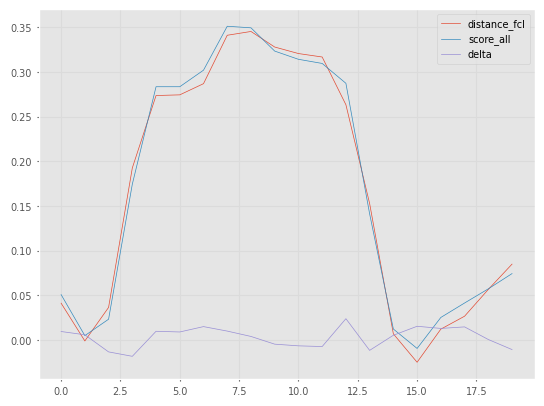

In [11]:
distance_fcl = cenv.distance(optim_options['init_solution'] )
print(distance_fcl)
score_all=col_func(optim_options['init_solution'].to(torch.float32)).cpu().detach().numpy()

import matplotlib.pyplot as plt
distance=np.expand_dims(distance_fcl, axis=1)
y1=np.array(distance)
y2=np.array(score_all)
delta=y2-y1
x=np.arange(len(y1))
plt.plot(x,y1,label='distance_fcl')
plt.plot(x,y2,label='score_all')
plt.plot(x,delta,label='delta')
plt.legend()
plt.show()

In [12]:
# Fastest, lower success rate and path quality
# optim_rec = adam_traj_optimize(
#     robot, col_func, start_cfg, target_cfg, optim_options)

# Medium success rate, better convergence than Adam(choose)
optim_rec = givengrad_traj_optimize(
    robot, col_func, start_cfg, target_cfg, optim_options)

# # Slowest, highest success rate and path quality
# optim_rec = trustconstr_traj_optimize(
#     robot, col_func, start_cfg, target_cfg, optim_options)

updated slsqp
con_collision_free= tensor([-0.038234, -0.127389,  0.000000,  0.000000,  0.000000,  0.000000,
         0.000000,  0.000000,  0.000000,  0.000000,  0.000000,  0.000000,
        -0.221467, -0.117547,  0.000000,  0.000000,  0.000000,  0.000000,
         0.000000], device='cuda:0', grad_fn=<SumBackward1>)
  NIT    FC           OBJFUN            GNORM
con_collision_free= tensor([-0.038234, -0.127389,  0.000000,  0.000000,  0.000000,  0.000000,
         0.000000,  0.000000,  0.000000,  0.000000,  0.000000,  0.000000,
        -0.221467, -0.117547,  0.000000,  0.000000,  0.000000,  0.000000,
         0.000000], device='cuda:0', grad_fn=<SumBackward1>)
con_collision_free= tensor([-0.038234, -0.127389,  0.000000,  0.000000,  0.000000,  0.000000,
         0.000000,  0.000000,  0.000000,  0.000000,  0.000000,  0.000000,
        -0.221467, -0.117547,  0.000000,  0.000000,  0.000000,  0.000000,
         0.000000], device='cuda:0', grad_fn=<SumBackward1>)
con_collision_free= tensor([ 0.

In [13]:
# Compare path cost before and after optimization
qs = optim_options['init_solution']
fk_points = robot.fkine(qs)
init_cost = (fk_points[1:] - fk_points[:-1]).pow(2).sum()
print(f'init cost = {init_cost}')
qs = optim_rec['solution']
qs = torch.tensor(qs)
fk_points = robot.fkine(qs)
cost = (fk_points[1:] - fk_points[:-1]).pow(2).sum()
print(f'cost = {cost}')
assert not torch.allclose(qs, optim_options['init_solution'].to(qs.dtype))

init cost = 1.6421130895614624
cost = 0.1573004126548767


In [14]:
from sdfsc.utils import dense_path
qs = dense_path(qs, 0.2)
print(f'qs.shape = {qs.shape}')
in_collision = cenv.is_collision(qs)
print([i for i, x in enumerate(in_collision) if x])
print(cenv.distance(qs[15:21]))
proxy_in_collision = (col_func(qs) - 0.002 < 0).reshape(-1)
print(proxy_in_collision)
print(f'Any in_collision ?: {any(in_collision)}')
print(f'Any proxy collision ?: {any(proxy_in_collision)}')
print(f'qs.shape = {qs.shape}')
import time
tmp_cenv.robot.q = start_cfg.numpy()
np.save('start_cfg_opt.npy',start_cfg.numpy())
tmp_cenv.env.step(0.01)
time.sleep(3)
for q in qs:
    tmp_cenv.robot.q = q.numpy()
    tmp_cenv.env.step(0.05)
    time.sleep(0.05)


qs.shape = torch.Size([52, 7])
[10, 11, 12]
[0.07650604634454387, 0.08327216207516126, 0.08556907402811381, 0.08525217174059663, 0.08195959748368803, 0.06619239164188825]
tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False], device='cuda:0')
Any in_collision ?: True
Any proxy collision ?: False
qs.shape = torch.Size([52, 7])


In [ ]:
# q_min = np.array([-2.8973, -1.7628, -2.8973, -
#                     3.0718, -2.8973, -0.0175, -2.8973])
# q_max = np.array([2.8973, 1.7628, 2.8973, -0.0698, 2.8973, 3.7525, 2.8973])
# q_rand=np.random.uniform(q_min, q_max, size=(7000, 7))
# distance_fcl = cenv.distance(q_rand)
# from segcdist.Segcdist import Segcdist
# score_all=col_func(q_rand).cpu()
# import matplotlib.pyplot as plt
# distance=np.expand_dims(distance_fcl, axis=1)
# y1=np.array(distance)
# y2=np.array(score_all.detach())


In [ ]:

# plt.scatter(y1, y2, s=3, c='blue', label='(FCL,SDF-SC)')
# plt.axis('equal')
# plt.plot([min(y1), max(y1)], [min(y1), max(y1)], linestyle='--', color='red', linewidth=2,label='y=x')
# plt.xlim(-0.1, 0.4)  
# plt.ylim(-0.1,0.4)  
# plt.xlabel('FCL', fontsize=11)
# plt.ylabel('SDF-SC', fontsize=11)
# plt.tick_params(axis='both', which='major', labelsize=8)  
# plt.legend(fontsize=8)
# plt.grid(color='b', linestyle='--', linewidth=0.5)
# plt.savefig('plan_data/FCLvsSDF-SC.png',dpi=800)
# plt.show()